### FIR fraction as a function of blackbody temperature.

In [3]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/netcdf_analysis/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/netcdf_analysis/Common/')

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

# Testing additional imports from Jen
from imports import (
    Path, LA, timeit, cfeature
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
from scipy.integrate import quad
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Script-specific imports

### Check running location and adjust working directory appropriately.

In [4]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

elif os.uname()[0] == 'Linux':
    print("Running through UCAR-CISL")

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
conv_dir ='convectivephase/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through UCAR-CISL
Can access all directory paths: False


---

### Function Definitions:

Planck function (for wavelength):

$ L = \frac{2\pi hc^2}{\lambda^5}\frac{1}{e^{hc/\lambda kT} - 1} $

$ [\frac{W}{m^2 m} ]$

Stefan-Boltzmann Law:

$ \sigma = \frac{2\pi^5k^4}{15h^3c^2}T^4 $ [W/m^2]

----

Define constants:

In [5]:
h=6.626e-34 # m2kgs-1
c=2.998e8 # m/s
k=1.381e-23 # m2kgs-2K-1
p=np.pi

---
Random:

In [6]:
from collections.abc import Iterable

def iterable(obj):
    return isinstance(obj, Iterable)

---

Initialize Planck and Stefan-Boltzmann equations:

In [7]:
def planck(lam, T):
    l = 2*p*h*c**2/(lam**5) * 1/(np.exp(h*c/(lam*k*T))-1)
    return l

def s_b(T):
    sig = (2*p**5*k**4)/(15*h**3*c**2)*(T**4)
    
    return sig

---

Verify the Planck function by comparing the numerical integration to the Stefan-Boltzmann Law:

In [8]:
for i in range(200,300,10):
    lams = np.linspace(10e-9,1000e-6,10000) # linear sampling from 100nm to 1000um
    
    stef = s_b(i)
    scipy_int = quad(planck,0,np.inf,args=(i))[0]
    np_int = np.trapz(planck(lams,i),x=lams)
    _err_scipy = scipy_int - stef
    _err_np = np_int - stef
    _pcterr_scipy = _err_scipy / stef *100
    _pcterr_np = _err_np / stef *100
    print("%sC, SciPy Error: %.4f%%, NumPy Error: %.4f%%." % (i, _pcterr_scipy, _pcterr_np))    

200C, SciPy Error: -0.0000%, NumPy Error: -0.0019%.
210C, SciPy Error: -0.0000%, NumPy Error: -0.0016%.
220C, SciPy Error: 0.0018%, NumPy Error: -0.0014%.
230C, SciPy Error: 0.0029%, NumPy Error: -0.0012%.
240C, SciPy Error: 0.0036%, NumPy Error: -0.0011%.
250C, SciPy Error: 0.0037%, NumPy Error: -0.0010%.
260C, SciPy Error: 0.0780%, NumPy Error: -0.0009%.
270C, SciPy Error: 0.0489%, NumPy Error: -0.0008%.
280C, SciPy Error: 0.0067%, NumPy Error: -0.0007%.
290C, SciPy Error: -0.0463%, NumPy Error: -0.0006%.


/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:5: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  """


---

Functions to calculate the FIR fraction of power radiated from a blackbody:

In [9]:
def fir_fraction(T):
    if iterable(T): # weird recursive list handling:
        out = []
        for i in T:
            out.append(fir_fraction(i))
        return out
    else:
        tot = quad(planck,0,np.inf,args=(T))[0]
        fir = quad(planck,15e-6,100e-6,args=(T))[0] # FIR is 15-100um
#         print(tot)
    
    return fir/tot *100

In [10]:
def fir_flux(T):
    if iterable(T): # weird recursive list handling:
        out = []
        for i in T:
            out.append(fir_flux(i))
        return out
    else:
#         tot = quad(planck,0,np.inf,args=(T))[0]
        fir = quad(planck,15e-6,100e-6,args=(T))[0] # FIR is 15-100um
#         print(tot)
    
    return fir

In [11]:
fir_flux(300)

198.0764397249746

In [12]:
s_b(300)

459.75904456476036

In [13]:
def fir_fraction_np(T):
    if iterable(T): # weird recursive list handling:
        out = []
        for i in T:
            out.append(fir_fraction_np(i))
        return out
    
    lams = np.linspace(10e-9,1000e-6,10000) # linear sampling from 10nm to 1000um
    
    tot = np.trapz(planck(lams,T),x=lams)
    fir = np.trapz(planck(lams[150:1000],T),x=lams[150:1000]) # FIR is 15-100um
    
    return fir/tot *100    

In [14]:
np.linspace(10e-9,1000e-6,10000)

array([1.00000000e-08, 1.10009001e-07, 2.10018002e-07, ...,
       9.99799982e-04, 9.99899991e-04, 1.00000000e-03])

---

Plot the Planck curve for several "earth-like" temperatures

In [15]:
# Quick function to convert wavelength ticks from m to um
def format_func(value, tick_number):
    return np.round(value*1e6, decimals=0)

In [16]:
# Quick function to convert wavelength ticks from m to um
def format_func_kc(value, tick_number):
    return value - 273.15
#     return np.round(value*1e6, decimals=0)

/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  
/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that 

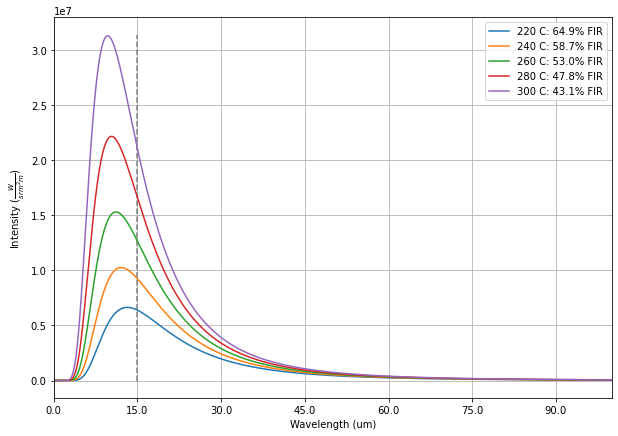

In [17]:
fig, ax = plt.subplots(figsize=[10,7])

lams = np.linspace(10e-9,1000e-6,10000) # linear sampling from 10nm to 1000um
t_range1 = np.arange(220,301,20)
for i in t_range1:
    ax.plot(lams,planck(lams,i),label="%.0f C: %.1f%% FIR" % (i, fir_fraction(i)))
#     print(fir_fraction(i))
    ax.grid()

ax.set_xlabel("Wavelength (um)")
ax.set_ylabel(r"Intensity ($ \frac{W}{sr m^2 m} )$")

# Make ticks in microns
ax.set_xticks(np.arange(0,91e-6,15e-6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

# ax.set_xscale('log')
ax.vlines(15e-6,ymin=0,ymax=np.pi*1e7,color='gray',linestyle='dashed')
ax.set_xbound(0,100e-6)

plt.legend()

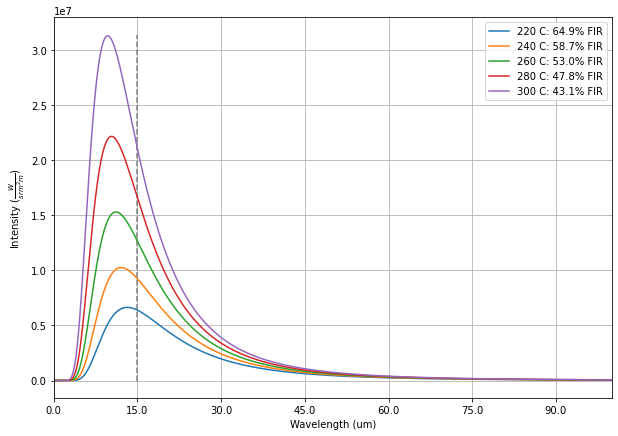

In [18]:
fig

---

Calculate the fraction of emitted energy in the FIR for a range of "earth-like" surface temperatures.

/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  
/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


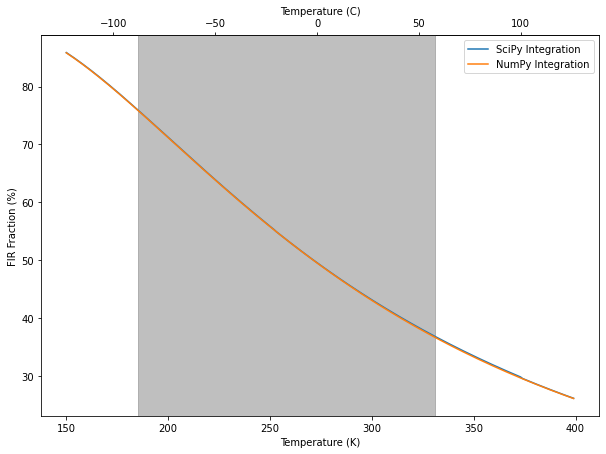

In [19]:
fig, ax = plt.subplots(figsize=[10,7])

t_span = range(150,400)
plt.plot(t_span,fir_fraction(t_span),label="SciPy Integration")
plt.plot(t_span,fir_fraction_np(t_span),label="NumPy Integration")
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("FIR Fraction (%)")

def k_to_c(k):
    return k - 273.15

def c_to_k(c):
    return c + 273.15

secax = ax.secondary_xaxis('top', functions=(k_to_c,c_to_k))
secax.set_xlabel('Temperature (C)')

plt.axvspan(185, 331, alpha=0.5, color='grey')

# ax.axvspan(8, 14, alpha=0.5, color='red')

## Using surface temperature to estimate change in the FIR fraction with predicted warming

Reading in the dataset (directly from Jen)

In [20]:
# read in the data - CESM2-LE (CESM postprocessed format, averaged across ensemble member, time fixed)

var='TS'
var_units='deg C'
datadir='/glade/work/jenkay/tunedice/ensmean/'
file='CESM2LE_'+var+'_ensmean_timeseries_hist_ssp370.nc'
ds_le = xr.open_dataset(datadir+file)
var_le_all = ds_le[var]
# print(var_le_all.shape)
# print(ds_le['time'])
# ds_le

### Select climatologies as the first and last 20 years

Time period is 1850-2100

In [21]:
hist_clim = ds_le.isel(time=slice(0,240))
fut_clim = ds_le.isel(time=slice(-240,None)) 
# ^this is weird, you should be able to use -1 to index :(

hist_clim = add_weights(hist_clim)
fut_clim = add_weights(fut_clim)

In [22]:
hist_months = hist_clim['TS'].groupby('time.month').mean()
hist_seasons = hist_clim['TS'].groupby('time.season').mean()
fut_months = fut_clim['TS'].groupby('time.month').mean()
fut_seasons = fut_clim['TS'].groupby('time.season').mean()

Mask convention is weird.

In [23]:
arctic_mask = hist_clim['lat'] < 70
weights = hist_clim['cell_weight']
seasons_list = ['DJF','MAM','JJA','SON']
months_list = ['Jan.','Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sep.','Oct.','Nov.','Dec.']
season_indices = range(1,12,3) # indexes for plotting against individual months
# .sel(season=season)

I could use the season_mean function here, but I would need to weight the grid areas separately.

In [24]:
hist_mon_avg = masked_average(hist_months,dim=['lat','lon'],mask=arctic_mask,weights=weights)
fut_mon_avg = masked_average(fut_months,dim=['lat','lon'],mask=arctic_mask,weights=weights)

In [25]:
hist_seas_avg = masked_average(hist_seasons,dim=['lat','lon'],mask=arctic_mask,weights=weights)
fut_seas_avg = masked_average(fut_seasons,dim=['lat','lon'],mask=arctic_mask,weights=weights)

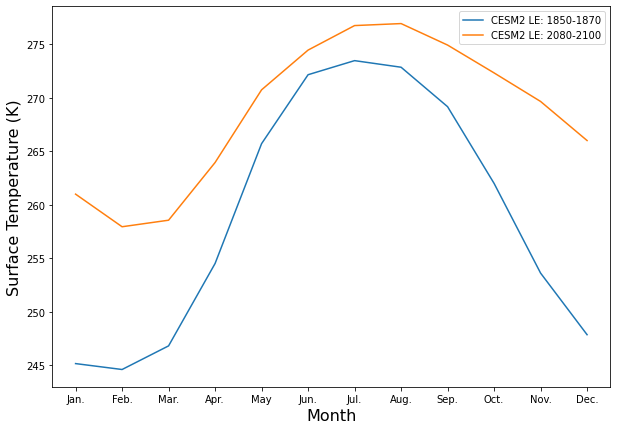

In [26]:
# plt.plot(np.array(hist_seas_avg))
fig,ax = plt.subplots(figsize=(10,7))
sorted_hist_seas_avg = []
sorted_fut_seas_avg = []
for season,i in zip(seasons_list,season_indices): # need because seasons aren't in order
    _hist = hist_seas_avg.sel(season=season)
    _fut = fut_seas_avg.sel(season=season)
    sorted_hist_seas_avg.append(_hist)
    sorted_fut_seas_avg.append(_fut)

# plt.scatter(season_indices,sorted_hist_seas_avg,marker='D',label='1850-1870 Season Avgs.')
# plt.scatter(season_indices,sorted_hist_seas_avg,marker='D',label='Historical Season Avgs.')
# plt.scatter(season_indices,sorted_fut_seas_avg,marker='D',label='2080-2100 Season Avgs.')
# plt.scatter(season_indices,sorted_fut_seas_avg,marker='D',label='2100 Season Avgs.')
plt.xticks(np.arange(1,len(months_list)+1,1), months_list)
ax.set_xlim(0.5,12.5) # weird that this is needed...

hist_mon_avg.plot(label='CESM2 LE: 1850-1870')
fut_mon_avg.plot(label='CESM2 LE: 2080-2100')
plt.ylabel("Surface Temperature (K)",fontsize=16)
plt.xlabel("Month",fontsize=16)

plt.legend()

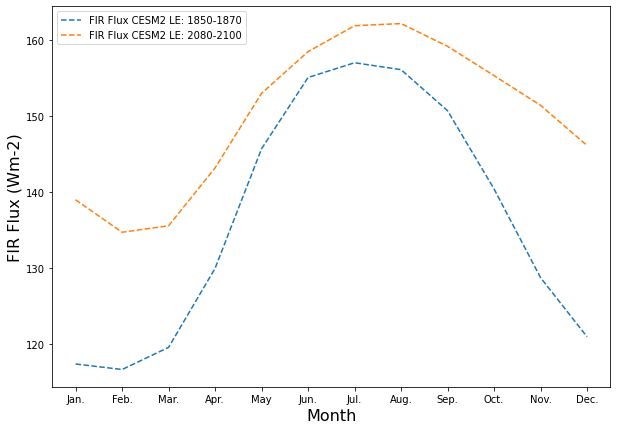

In [47]:
fig,ax = plt.subplots(figsize=(10,7))

offset = np.arange(1,len(months_list)+1,1)
plt.xticks(offset, months_list)
ax.set_xlim(0.5,12.5) # weird that this is needed...

# l1 = ax.plot(offset, hist_mon_avg, label='CESM2 LE: 1850-1870')
# l2 = ax.plot(offset, fut_mon_avg, label='CESM2 LE: 2080-2100')

# ax.set_ylabel("Surface Temperature (K)",fontsize=16)
# ax.set_xlabel("Month",fontsize=16)

# ax2 = ax.twinx()
ax.set_ylabel("FIR Flux (Wm-2)",fontsize=16)
ax.set_xlabel("Month",fontsize=16)

ax.plot(offset, fir_flux(np.array(hist_mon_avg)), label='FIR Flux CESM2 LE: 1850-1870',linestyle='dashed')
ax.plot(offset, fir_flux(np.array(fut_mon_avg)), label='FIR Flux CESM2 LE: 2080-2100',linestyle='dashed')

# ax2.set_ybound(116,166) # Offset manually (114.33624151694825, 164.49793594521816)

# handles = [l1[0],l2[0],l3[0],l4[0]]
# labels = ['Temperature (K) CESM2 LE: 1850-1870','Temperature (K) CESM2 LE: 2080-2100','FIR Flux CESM2 LE: 1850-1870','FIR Flux CESM2 LE: 2080-2100']

# ax.legend(handles=handles,labels=labels)
ax.legend()

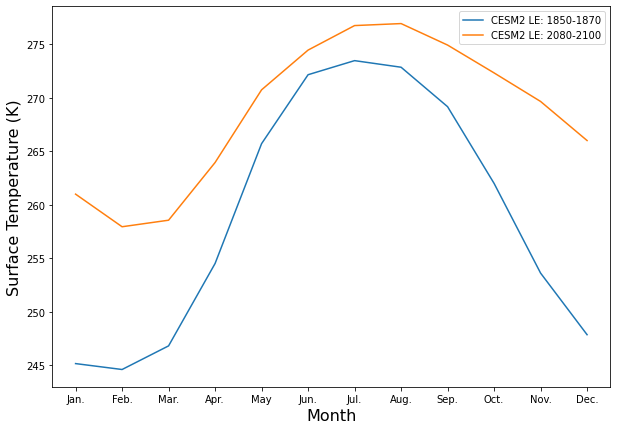

In [26]:
# plt.plot(np.array(hist_seas_avg))
fig,ax = plt.subplots(figsize=(10,7))
sorted_hist_seas_avg = []
sorted_fut_seas_avg = []
for season,i in zip(seasons_list,season_indices): # need because seasons aren't in order
    _hist = hist_seas_avg.sel(season=season)
    _fut = fut_seas_avg.sel(season=season)
    sorted_hist_seas_avg.append(_hist)
    sorted_fut_seas_avg.append(_fut)

# plt.scatter(season_indices,sorted_hist_seas_avg,marker='D',label='1850-1870 Season Avgs.')
# plt.scatter(season_indices,sorted_hist_seas_avg,marker='D',label='Historical Season Avgs.')
# plt.scatter(season_indices,sorted_fut_seas_avg,marker='D',label='2080-2100 Season Avgs.')
# plt.scatter(season_indices,sorted_fut_seas_avg,marker='D',label='2100 Season Avgs.')
plt.xticks(np.arange(1,len(months_list)+1,1), months_list)
ax.set_xlim(0.5,12.5) # weird that this is needed...

hist_mon_avg.plot(label='FIR Flux CESM2 LE: 1850-1870')
fut_mon_avg.plot(label='FIR Flux CESM2 LE: 2080-2100')
plt.ylabel("Far Infrared Flux (Wm-2)",fontsize=16)
plt.xlabel("Month",fontsize=16)

plt.legend()

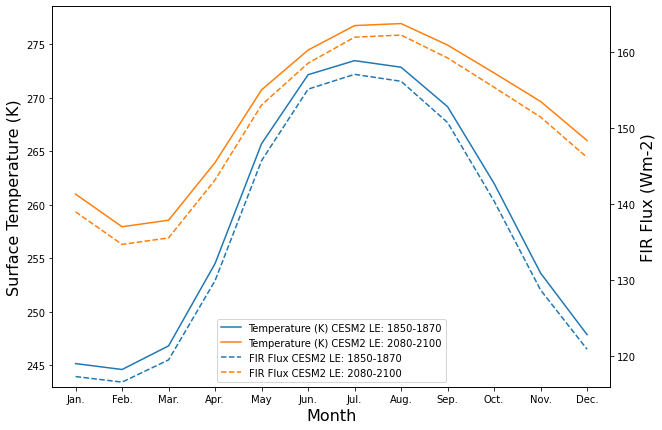

In [27]:
fig,ax = plt.subplots(figsize=(10,7))

offset = np.arange(1,len(months_list)+1,1)
plt.xticks(offset, months_list)
ax.set_xlim(0.5,12.5) # weird that this is needed...

l1 = ax.plot(offset, hist_mon_avg, label='CESM2 LE: 1850-1870')
l2 = ax.plot(offset, fut_mon_avg, label='CESM2 LE: 2080-2100')

ax.set_ylabel("Surface Temperature (K)",fontsize=16)
ax.set_xlabel("Month",fontsize=16)

ax2 = ax.twinx()
ax2.set_ylabel("FIR Flux (Wm-2)",fontsize=16)

l3 = ax2.plot(offset, fir_flux(np.array(hist_mon_avg)), label='CESM2 LE: 1850-1870',linestyle='dashed')
l4 = ax2.plot(offset, fir_flux(np.array(fut_mon_avg)), label='CESM2 LE: 2080-2100',linestyle='dashed')

ax2.set_ybound(116,166) # Offset manually (114.33624151694825, 164.49793594521816)

handles = [l1[0],l2[0],l3[0],l4[0]]
labels = ['Temperature (K) CESM2 LE: 1850-1870','Temperature (K) CESM2 LE: 2080-2100','FIR Flux CESM2 LE: 1850-1870','FIR Flux CESM2 LE: 2080-2100']

ax.legend(handles=handles,labels=labels)

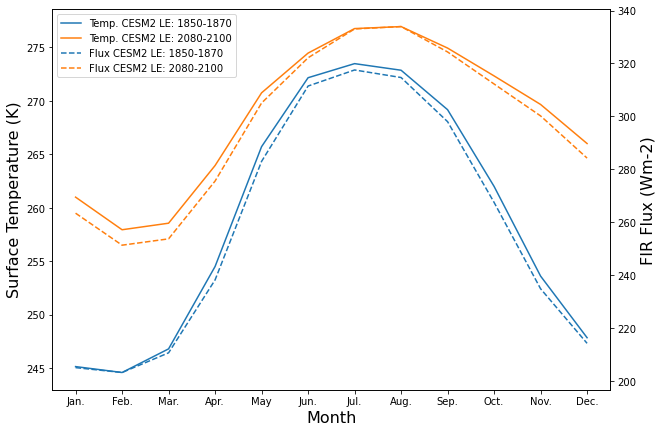

In [28]:
fig,ax = plt.subplots(figsize=(10,7))

offset = np.arange(1,len(months_list)+1,1)
plt.xticks(offset, months_list)
ax.set_xlim(0.5,12.5) # weird that this is needed...

l1 = ax.plot(offset, hist_mon_avg, label='Temp. CESM2 LE: 1850-1870')
l2 = ax.plot(offset, fut_mon_avg, label='Temp. CESM2 LE: 2080-2100')

ax.set_ylabel("Surface Temperature (K)",fontsize=16)
ax.set_xlabel("Month",fontsize=16)

ax2 = ax.twinx()
ax2.set_ylabel("FIR Flux (Wm-2)",fontsize=16)

l3 = ax2.plot(offset, s_b(np.array(hist_mon_avg)), label='Flux CESM2 LE: 1850-1870',linestyle='dashed')
l4 = ax2.plot(offset, s_b(np.array(fut_mon_avg)), label='Flux CESM2 LE: 2080-2100',linestyle='dashed')

handles = [l1[0],l2[0],l3[0],l4[0]]
labels = ['Temp. CESM2 LE: 1850-1870','Temp. CESM2 LE: 2080-2100','Flux CESM2 LE: 1850-1870','Flux CESM2 LE: 2080-2100']
# ax2.set_ybound(100,180)

ax.legend(labels=labels,handles=handles)

In [29]:
sorted_hist_mon_avg = []
sorted_fut_mon_avg = []
for _h,_f in zip(sorted_hist_mon_avg,sorted_fut_mon_avg): # need because seasons aren't in order
    _hist = hist_seas_avg.sel(season=season)
    _fut = fut_seas_avg.sel(season=season)
    sorted_hist_seas_avg.append(_hist)
    sorted_fut_seas_avg.append(_fut)

Testing the averaging as a reality check, looks good.

---

/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  


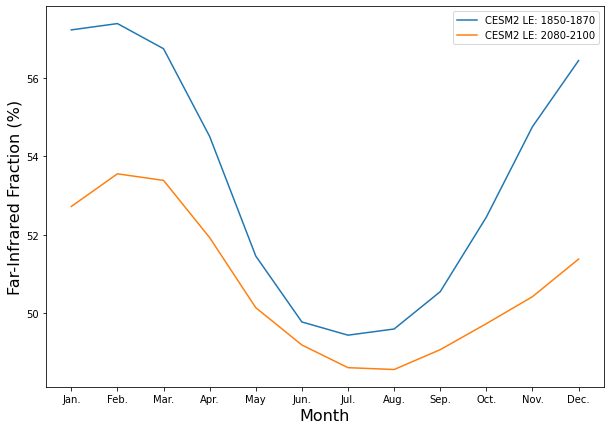

In [30]:
fig,ax = plt.subplots(figsize=(10,7))

plt.plot(fir_fraction(np.array(hist_mon_avg)),label='CESM2 LE: 1850-1870') # again, janky
plt.plot(fir_fraction(np.array(fut_mon_avg)),label='CESM2 LE: 2080-2100')

plt.xticks(np.arange(0,len(months_list),1), months_list)
# plt.xticks(months_list)
ax.set_ylabel("Far-Infrared Fraction (%)",fontsize=16)
ax.set_xlabel("Month",fontsize=16)
# ax.set_xlim(0.5,12.5) # weird that this is needed...

plt.legend()

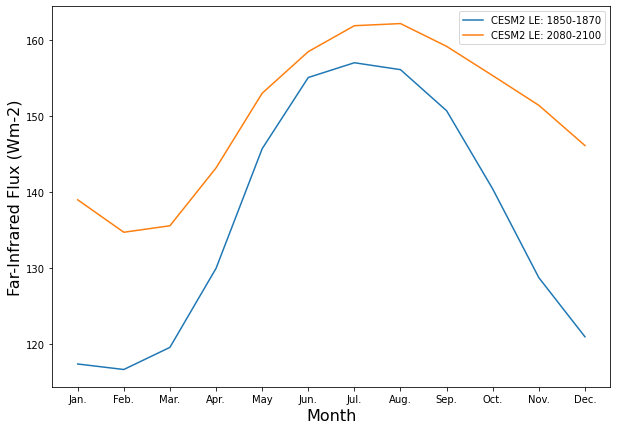

In [31]:
fig,ax = plt.subplots(figsize=(10,7))

plt.plot(fir_flux(np.array(hist_mon_avg)),label='CESM2 LE: 1850-1870') # again, janky
plt.plot(fir_flux(np.array(fut_mon_avg)),label='CESM2 LE: 2080-2100')

plt.xticks(np.arange(0,len(months_list),1), months_list)
# plt.xticks(months_list)
ax.set_ylabel("Far-Infrared Flux (Wm-2)",fontsize=16)
ax.set_xlabel("Month",fontsize=16)
# ax.set_xlim(0.5,12.5) # weird that this is needed...

plt.legend()

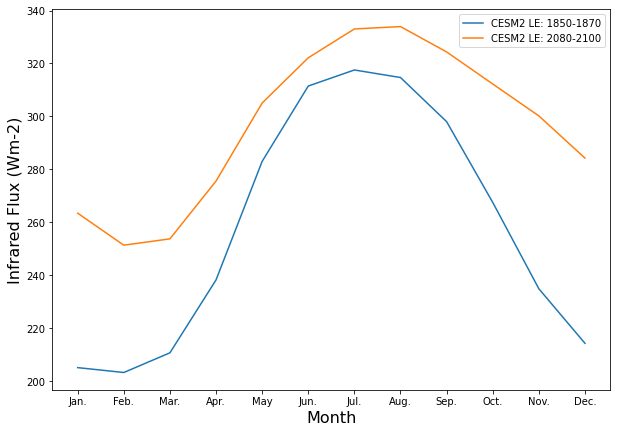

In [32]:
fig,ax = plt.subplots(figsize=(10,7))

plt.plot(s_b(np.array(hist_mon_avg)),label='CESM2 LE: 1850-1870') # again, janky
plt.plot(s_b(np.array(fut_mon_avg)),label='CESM2 LE: 2080-2100')

plt.xticks(np.arange(0,len(months_list),1), months_list)
# plt.xticks(months_list)
ax.set_ylabel("Infrared Flux (Wm-2)",fontsize=16)
ax.set_xlabel("Month",fontsize=16)
# ax.set_xlim(0.5,12.5) # weird that this is needed...

plt.legend()

In [33]:
fig.savefig("FIR_fraction_monthly.png",format = 'png', dpi = 200)
# to_png(fig,"FIR_fraction_monthly")

/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  


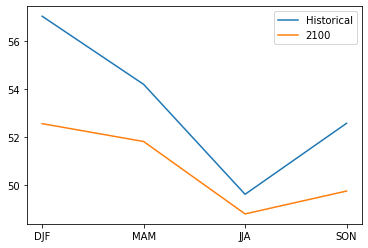

In [34]:
plt.plot(fir_fraction(np.array(sorted_hist_seas_avg)),label='Historical') # again, janky
plt.plot(fir_fraction(np.array(sorted_fut_seas_avg)),label='2100')

plt.xticks(range(4),seasons_list)
plt.legend()

/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


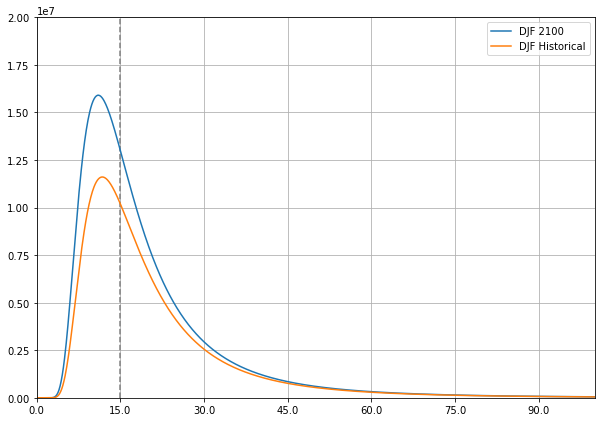

In [35]:
lams = np.linspace(10e-9,1000e-6,10000) # linear sampling from 10nm to 1000um

fig, ax = plt.subplots(figsize=[10,7])

ax.plot(lams, planck(lams,262),label='DJF 2100')
ax.plot(lams, planck(lams,246),label='DJF Historical')

ax.set_xticks(np.arange(0,91e-6,15e-6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.set_xlim(0,100e-6)
ax.set_ylim(0,2e7)
ax.grid()
ax.vlines(15e-6,ymin=0,ymax=2e7,color='gray',linestyle='dashed')

plt.legend()

In [36]:
lams

array([1.00000000e-08, 1.10009001e-07, 2.10018002e-07, ...,
       9.99799982e-04, 9.99899991e-04, 1.00000000e-03])

In [37]:
fir_fraction_np([250,265])

/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[55.779170862074324, 51.630280540828345]

CAM6 RRTMG LW Bands (cm-1):  
1 10–350  
2 350 – 500  
3 500 – 630  
4 630 – 700  
5 700 – 820  
6 820 – 980  
7 980 – 1080  
8 1080 – 1180  
9 1180 – 1390  
10 1390 – 1480  
11 1480 – 1800  
12 1800 – 2080  
13 2080 – 2250  
14 2250 – 2380  
15 2380 – 2600  
16 2600 – 3250  

In [38]:
def wavenumber_to_wavelength(wn):
    _wn = np.array(wn)
    # c = f*lambda [m/s]
    # 1/lambda = f/c [1/m]
    # wn = 1/100*1/lambda = f/c*1/100
    # lambda = 1/(100*wn) [m]
    return 1/(100*_wn)

In [39]:
wn_cam6 = [10,350,500,630,700,820,980,1080,1180,1390,1480,1800,2080,2250,2380,2600,3250]

In [40]:
wavenumber_to_wavelength(wn_cam6)*1e6

array([1000.        ,   28.57142857,   20.        ,   15.87301587,
         14.28571429,   12.19512195,   10.20408163,    9.25925926,
          8.47457627,    7.1942446 ,    6.75675676,    5.55555556,
          4.80769231,    4.44444444,    4.20168067,    3.84615385,
          3.07692308])

In [41]:
def fir_fraction_np_rrtmg(T):
    if iterable(T): # weird recursive list handling:
        out = []
        for i in T:
            out.append(fir_fraction_np(i))
        return out
    
    wn_cam6 = [10,350,500,630,700,820,980,1080,1180,1390,1480,1800,2080,2250,2380,2600,3250]
    lams = np.flip(wavenumber_to_wavelength(wn_cam6))
    
    tot = np.trapz(planck(lams[:-1],T),x=lams[:-1])
    fir = np.trapz(planck(lams[-4:-1],T),x=lams[-4:-1]) # FIR is 15.87-100um
    
    print(tot)
    return fir/tot *100    

In [42]:
np.flip(lams)

array([1.00000000e-03, 9.99899991e-04, 9.99799982e-04, ...,
       2.10018002e-07, 1.10009001e-07, 1.00000000e-08])

/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  
/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  
/glade/work/jonahshaw/miniconda3/envs/analysis_pyngl_ffmpeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed

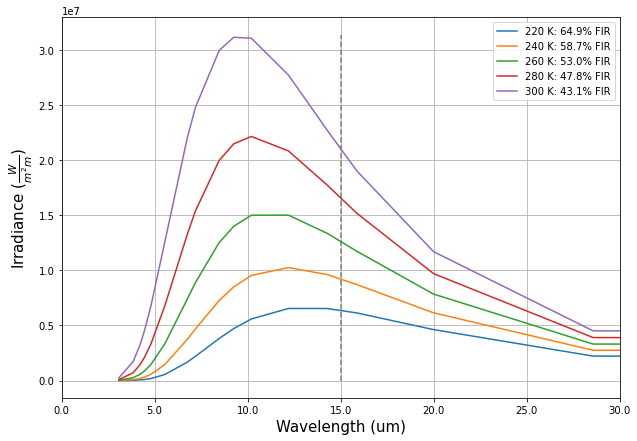

In [43]:
fig, ax = plt.subplots(figsize=[10,7])

wn_cam6 = [10,350,500,630,700,820,980,1080,1180,1390,1480,1800,2080,2250,2380,2600,3250]
lams = wavenumber_to_wavelength(wn_cam6)

t_range1 = np.arange(220,301,20)
for i in t_range1:
    ax.plot(lams,planck(lams,i),label="%.0f K: %.1f%% FIR" % (i, fir_fraction(i)))
#     ax.plot(lams,planck(lams,i),label="%.0f K: %.1f%% FIR" % (i, fir_fraction_np_rrtmg(i)))
#     print(fir_fraction(i))
    ax.grid()

ax.set_xlabel("Wavelength (um)",fontsize=15)
ax.set_ylabel(r"Irradiance ($ \frac{W}{m^2 m} )$",fontsize=15)
# ax.set_ylabel(r"Intensity ($ \frac{W}{sr m^2 m} )$",fontsize=15)

# Make ticks in microns
# ax.set_xticks(lams)
# ax.set_xticks(np.arange(0,91e-6,15e-6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

# ax.set_xscale('log')
ax.vlines(15e-6,ymin=0,ymax=np.pi*1e7,color='gray',linestyle='dashed')
ax.set_xbound(0,30e-6)
# ax.set_xbound(0,100e-6)

plt.legend()